In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import random 

np.random.seed(123456)

In [37]:
# Evaluate Complexity of Nonlinear Dynamics: 

dt = 0.1
timeframe = 16
time = np.arange(0, timeframe+dt, dt)

def standard_kinematics(state, v, omega): 
    return np.array([state[0] + dt * v * np.cos(state[2]),   
                     state[1] + dt * v * np.sin(state[2]),   
                     state[2] + dt * omega])


def dynamics_a(state):
    x_t = state[0]
    v_t = state[1]
    a_t = state[2]
    return np.array([np.sin(x_t) + (v_t * np.cos(a_t) * dt), 
                    np.cos(x_t) + (np.sin(v_t) * dt), 
                    x_t + (np.cos(v_t) * dt)])


def dynamics_b(state): 
    x_t = state[0]
    v_t = state[1]
    a_t = state[2]
    return np.array([np.cos(x_t) + (a_t * np.cos(v_t) * dt), 
                     np.sin(x_t) + (np.sin(v_t) * dt), 
                     np.sin(a_t) + (v_t * dt)])


# Simulate dynamics
initial_state_kin = np.array([0.0, 0.0, 0.0])  
initial_state_a = np.array([0.0, 0.0, 0.0])  
initial_state_b = np.array([0.0, 0.0, 0.0])  


kin_trajectory = np.zeros((len(time), 3)) 
a_trajectory = np.zeros((len(time), 3)) 
b_trajectory = np.zeros((len(time), 3)) 

state_kin, state_a, state_b = initial_state_kin, initial_state_a, initial_state_b

for i in range(1, len(time)):
    kin_trajectory[i] = state_kin
    a_trajectory[i] = state_a
    b_trajectory[i] = state_b
    
    state_kin += standard_kinematics(state_kin, 1, np.sin(i)) * dt
    state_a += dynamics_a(state_a) * dt
    state_b += dynamics_b(state_b) * dt


def shannon_entropy(data, num_bins=10):
    bins, _ = np.histogram(data, bins=num_bins, density=True)
    entropy = -np.sum(bins * np.log2(bins + 1e-12))
    return entropy


kin_entropy_x = shannon_entropy(kin_trajectory[:, 0]) 
kin_entropy_y = shannon_entropy(kin_trajectory[:, 1]) 
kin_entropy_theta = shannon_entropy(kin_trajectory[:, 2]) 
mean_kin = (kin_entropy_x + kin_entropy_y + kin_entropy_theta) / 3

a_entropy_x = shannon_entropy(a_trajectory[:, 0]) 
a_entropy_v = shannon_entropy(a_trajectory[:, 1]) 
a_entropy_a = shannon_entropy(a_trajectory[:, 2]) 
mean_a = (a_entropy_x + a_entropy_v + a_entropy_a) / 3

b_entropy_x = shannon_entropy(b_trajectory[:, 0]) 
b_entropy_v = shannon_entropy(b_trajectory[:, 1]) 
b_entropy_a = shannon_entropy(b_trajectory[:, 2])
mean_b = (b_entropy_x + b_entropy_v + b_entropy_a) / 3

print("Entropy for Kinematics x:", kin_entropy_x)
print("Entropy for Kinematics y:", kin_entropy_y)
print("Entropy for Kinematics theta:", kin_entropy_theta)
print("Mean Entropy for Kinematics:", mean_kin, "\n")


print("Entropy for a_dynamics x:", a_entropy_x)
print("Entropy for a_dynamics v:", a_entropy_v)
print("Entropy for a_dynamics a:", a_entropy_a)
print("Mean Entropy for a_dynamics:", mean_a, "\n")


print("Entropy for b_dynamics x:", b_entropy_x)
print("Entropy for b_dynamics v:", b_entropy_v)
print("Entropy for b_dynamics a:", b_entropy_a)
print("Mean Entropy for b_dynamics:", mean_b, "\n")


print(f'Trajectory from a_dynamics has {mean_a / mean_kin} times more entropy than the standard kinematics model')
print(f'Trajectory from b_dynamics has {mean_b / mean_kin} times more entropy than the standard kinematics model')

Entropy for Kinematics x: 0.0004322808350720767
Entropy for Kinematics y: 0.006937734183169361
Entropy for Kinematics theta: 0.00370878855514255
Mean Entropy for Kinematics: 0.003692934524461329 

Entropy for a_dynamics x: 2.0939974725690487
Entropy for a_dynamics v: 2.917827869833805
Entropy for a_dynamics a: 1.301764846423269
Mean Entropy for a_dynamics: 2.104530062942041 

Entropy for b_dynamics x: 0.4391512894947136
Entropy for b_dynamics v: 2.5904736755937963
Entropy for b_dynamics a: 3.6969738736073112
Mean Entropy for b_dynamics: 2.2421996128986073 

Trajectory from a_dynamics has 569.8801451804832 times more entropy than the standard kinematics model
Trajectory from b_dynamics has 607.1593195185789 times more entropy than the standard kinematics model


In [209]:
class UKF():  
    # Goal: Estimate state vector x, v, a in one physical dimension
    def __init__(self): 
        self.dt = 0.1
        self.total_duration = 16
        self.time = np.arange(0, self.total_duration + self.dt, self.dt)
        self.lamb = 3
        
        self.state_len = 3
        self.mu_ukf = np.zeros((3, len(self.time)))
        self.mu_ukf[:, 0] = [1, 1, 1]    # initialize initial state 
        self.cov_ukf = [np.eye(3) for j in range(len(self.time))]
        
        self.ground_truth = np.zeros((3, len(self.time)))
        self.ground_truth[:, 0] = [1, 1, 1]
        
        self.baseline = np.zeros((3, len(self.time)))
        self.baseline[:, 0] = [1, 1, 1]
        
        self.Q = 0.1 * np.eye(3)
        self.R = 0.1 * np.eye(3)
        
    
    # Dynamics for time slices first fourth and third fourth 
    def nonlinear_fluc_dynamics_a(self, state_control): 
        x_t = state_control[0]
        v_t = state_control[1]
        a_t = state_control[2]
        D_a = np.array([np.sin(x_t) + (v_t * np.cos(a_t) * self.dt), 
                        np.cos(x_t) + (np.sin(v_t) * self.dt), 
                        x_t + (np.cos(v_t) * self.dt)])
        return D_a
    
    # Dynamics for time slices second fourth and last fourth 
    def nonlinear_fluc_dynamics_b(self, state_control): 
        x_t = state_control[0]
        v_t = state_control[1]
        a_t = state_control[2]
        D_b = np.array([np.cos(x_t) + (a_t * np.cos(v_t) * self.dt), 
                        np.sin(x_t) + (np.sin(v_t) * self.dt), 
                        np.sin(a_t) + (v_t * self.dt)])
        return D_b
    
    def measurement_model(self, state_control):
        x_p = state_control[0]
        v_p = state_control[1]
        a_p = state_control[2]
        return np.array([np.sin(x_p) * (np.cos(v_p) + np.sin(a_p)), np.cos(v_p), np.sin(a_p)])
    
    def ukf_transf(self, mu, cov, weights, nonlinear_model): 
        n = len(mu)   # dimension of state space 
        matrix_cholesky = (n + self.lamb) * cov
        matrix_cholesky += 1e-6 * np.eye(matrix_cholesky.shape[0])
        perturb_matrix = cholesky(matrix_cholesky, lower=True).T
        S = [mu]
        for i in range(n):   # create sigma points  
            S.append(mu + perturb_matrix[i])
            S.append(mu - perturb_matrix[i])
        updated_S = [nonlinear_model(s) for s in S]
        updated_mu = sum(w * s for w, s in zip(weights, updated_S))
        updated_cov = sum(w * np.outer(s - updated_mu, s - updated_mu) for w, s in zip(weights, updated_S))        
        return updated_mu, updated_cov, S, updated_S
    
    def ukf_execute(self): 
        weights = [self.lamb / (self.state_len + self.lamb)] + [1 / (2 * (self.state_len + self.lamb))] * (2 * self.state_len)
        n = len(self.time)
        for i in range(1, n):
            dyn_noise = np.random.multivariate_normal(np.zeros((3,)), self.Q)
            obs_noise = np.random.multivariate_normal(np.zeros((3,)), self.R)
                        
            mu_p = cov_p = S_p = updated_S_p = None
            
            # Predict Step
            prob_threshold = 0.5
            random_prob = random.uniform(0, 1)

            if random_prob < prob_threshold: 
                mu_p, cov_p, S_p, updated_S_p = self.ukf_transf(self.mu_ukf[:, i-1], self.cov_ukf[i-1], weights, self.nonlinear_fluc_dynamics_a)
                self.ground_truth[:, i] = self.nonlinear_fluc_dynamics_a(self.ground_truth[:, i-1]) + dyn_noise
            else:
                mu_p, cov_p, S_p, updated_S_p = self.ukf_transf(self.mu_ukf[:, i-1], self.cov_ukf[i-1], weights, self.nonlinear_fluc_dynamics_b)
                self.ground_truth[:, i] = self.nonlinear_fluc_dynamics_b(self.ground_truth[:, i-1]) + dyn_noise
                        
            # Update Step 
            o = self.measurement_model(self.ground_truth[:, i]) + obs_noise
            mu_o, cov_o, S_o, updated_S_o = self.ukf_transf(mu_p, cov_p, weights, self.measurement_model)         
            mu_o += obs_noise
            cross_cov = sum(w * np.outer(s - mu_p, updated_s - mu_o) for w, s, updated_s in zip(weights, S_o, updated_S_o))
            cov_o += 1e-6 * np.eye(cov_o.shape[0])
            K = cross_cov @ np.linalg.inv(cov_o)
            self.mu_ukf[:, i] = mu_p + K @ (o - mu_o) + dyn_noise
            self.cov_ukf[i] = cov_p - K @ cov_o @ K.T
            
            self.baseline[:, i] = o

In [210]:
ukf = UKF()
ukf.ukf_execute()

In [223]:
# Pose
rmse_pose = np.sqrt(np.mean((ukf.mu_ukf[0] - ukf.ground_truth[0]) ** 2))
mae_pose = np.mean(np.abs(ukf.mu_ukf[0] - ukf.ground_truth[0]))

rmse_base_pose = np.sqrt(np.mean((ukf.baseline[0] - ukf.ground_truth[0]) ** 2))
mae_base_pose = np.mean(np.abs(ukf.baseline[0] - ukf.ground_truth[0]))

# Velocity
rmse_vel = np.sqrt(np.mean((ukf.mu_ukf[1] - ukf.ground_truth[1]) ** 2))
mae_vel = np.mean(np.abs(ukf.mu_ukf[1] - ukf.ground_truth[1]))

rmse_base_vel = np.sqrt(np.mean((ukf.baseline[1] - ukf.ground_truth[1]) ** 2))
mae_base_vel = np.mean(np.abs(ukf.baseline[1] - ukf.ground_truth[1]))

# Acceleration

rmse_accel = np.sqrt(np.mean((ukf.mu_ukf[2] - ukf.ground_truth[2]) ** 2))
mae_accel = np.mean(np.abs(ukf.mu_ukf[2] - ukf.ground_truth[2]))

rmse_base_accel = np.sqrt(np.mean((ukf.baseline[2] - ukf.ground_truth[2]) ** 2))
mae_base_accel = np.mean(np.abs(ukf.baseline[2] - ukf.ground_truth[2]))


# MAE
print(f'MAE for Pose: {mae_pose}')
print(f'MAE for Velocity: {mae_vel}')
print(f'MAE for Acceleration: {mae_accel}')
mean_MAE = (mae_pose + mae_vel + mae_accel) / 3
print(f'Mean MAE for UKF: {mean_MAE}\n')

print(f'Baseline MAE for Pose: {mae_base_pose}')
print(f'Baseline MAE for Velocity: {mae_base_vel}')
print(f'Baseline MAE for Acceleration: {mae_base_accel}')
b_mean_MAE = (mae_base_pose + mae_base_vel + mae_base_accel) / 3
print(f'Mean MAE for Baseline: {b_mean_MAE}\n')


# RMSE
print(f'RMSE for Pose: {rmse_pose}')
print(f'RMSE for Velocity: {rmse_vel}')
print(f'RMSE for Acceleration: {rmse_accel}')
mean_RSME = (rmse_pose + rmse_vel + rmse_accel) / 3
print(f'Mean RMSE for UKF: {mean_RSME}\n')


print(f'Baseline RMSE for Pose: {rmse_base_pose}')
print(f'Baseline RMSE for Velocity: {rmse_base_vel}')
print(f'Baseline RMSE for Acceleration: {rmse_base_accel}')
b_mean_RSME = (rmse_base_pose + rmse_base_vel + rmse_base_accel) / 3
print(f'Mean RMSE for Baseline: {b_mean_RSME}\n')

# Mean comparison
MAE_percent_decrease = ((mean_MAE - b_mean_MAE) / b_mean_MAE) * 100
print(f'UKF shows {-MAE_percent_decrease}% decrease in MAE compared to baseline')

RMSE_percent_decrease = ((mean_RSME - b_mean_RSME) / b_mean_RSME) * 100
print(f'UKF shows {-RMSE_percent_decrease}% decrease in RSME compared to baseline')
print(f'Overall UKF shows {-(MAE_percent_decrease + RMSE_percent_decrease) / 2}% increase in performance compared to baseline!')



MAE for Pose: 0.07939974832458184
MAE for Velocity: 0.07523546613928153
MAE for Acceleration: 0.08203213318584232
Mean MAE for UKF: 0.07888911588323523

Baseline MAE for Pose: 0.3926464393455951
Baseline MAE for Velocity: 0.6033549616038308
Baseline MAE for Acceleration: 0.2877033219977227
Mean MAE for Baseline: 0.42790157431571624

RMSE for Pose: 0.12051695655308102
RMSE for Velocity: 0.13052277736464432
RMSE for Acceleration: 0.1189676323176438
Mean RMSE for UKF: 0.12333578874512303

Baseline RMSE for Pose: 0.48204955541301225
Baseline RMSE for Velocity: 0.7415444399487369
Baseline RMSE for Acceleration: 0.36288422393210257
Mean RMSE for Baseline: 0.5288260730979506

UKF shows 81.56372385182465% decrease in MAE compared to baseline
UKF shows 76.67743800478641% decrease in RSME compared to baseline
Overall UKF shows 79.12058092830553% increase in performance compared to baseline!


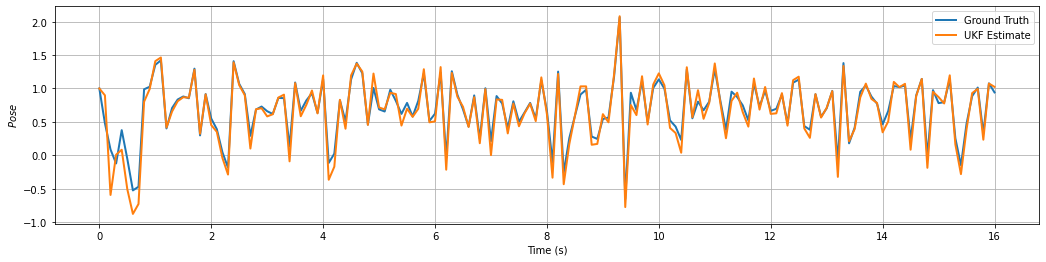

In [224]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.title('')
plt.plot(ukf.time, ukf.ground_truth[0, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[0, :], linewidth=2, label='UKF Estimate')

plt.xlabel('Time (s)')
plt.ylabel(r'$Pose$')
plt.legend()
plt.grid(True)

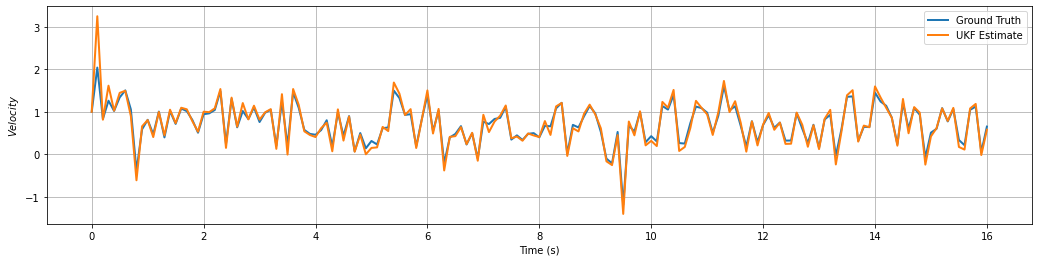

In [225]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.plot(ukf.time, ukf.ground_truth[1, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[1, :], linewidth=2, label='UKF Estimate')

plt.xlabel('Time (s)')
plt.ylabel(r'$Velocity$')
plt.legend()
plt.grid(True)

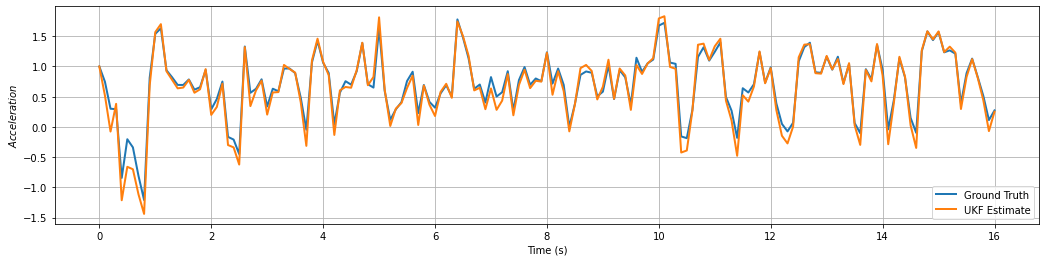

In [226]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.plot(ukf.time, ukf.ground_truth[2, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[2, :], linewidth=2, label='UKF Estimate')

plt.xlabel('Time (s)')
plt.ylabel(r'$Acceleration$')
plt.legend()
plt.grid(True)